### Parameter Settings

In [1]:
from tqdm import tqdm_notebook
from rouge import Rouge
rouge = Rouge()

import tensorflow as tf
import sys
import numpy as np
from data import Data
from model_gan_baseline import SummaryModel
import argparse
import os
import matplotlib.pyplot as plt
import matplotlib

tf.logging.set_verbosity('ERROR')

parser = argparse.ArgumentParser(description = 'Train/Test summarization model', formatter_class = argparse.ArgumentDefaultsHelpFormatter)

# Import Setting
parser.add_argument("--doc_file", type = str, default = './data/doc.p', help = 'path to document file')
parser.add_argument("--vocab_file", type = str, default = './data/vocab.p', help = 'path to vocabulary file')
parser.add_argument("--emb_file", type = str, default = './data/emb.p', help = 'path to embedding file')
parser.add_argument("--src_time", type = int, default = 1000, help = 'maximal # of time steps in source text')
parser.add_argument("--sum_time", type = int, default = 120, help = 'maximal # of time steps in summary')
parser.add_argument("--max_oov_bucket", type = int, default = 280, help = 'maximal # of out-of-vocabulary word in one summary')
parser.add_argument("--train_ratio", type = float, default = 0.9, help = 'ratio of training data')
parser.add_argument("--seed", type = int, default = 888, help = 'seed for spliting data')

# Saving Setting
parser.add_argument("--log", type = str, default = './log/', help = 'logging directory')
parser.add_argument("--save", type = str, default = './model/', help = 'model saving directory')
parser.add_argument("--load_pretrain", type = bool, default = False, help = 'whether load from old version pre-trained model')
parser.add_argument("--checkpoint", type = str, help = 'path to checkpoint point')
parser.add_argument("--autosearch", type = bool, default = False, help = "[NOT AVAILABLE] Set 'True' if searching for latest checkpoint")
parser.add_argument("--save_interval", type = int, default = 2000, help = "Save interval for training")

# Hyperparameter Setting
parser.add_argument("--batch_size", type = int, default = 16, help = 'number of samples in one batch')
parser.add_argument("--gen_lr", type = float, default = 1e-3, help = 'learning rate for generator')
parser.add_argument("--dis_lr", type = float, default = 1e-3, help = 'learning rate for discriminator')
parser.add_argument("--cov_weight", type = float, default = 1., help = 'weight for coverage loss');

### Initialize & Load Model

In [2]:
params = vars(parser.parse_args([]))
params['load_pretrain'] = True
# params['checkpoint'] = './model/one_emb/pointer_cov_supervised-54000' # Uncomment when requiring reloading model
# params['checkpoint'] = './model/one_emb/cov_after_2_epoch-2' # Uncomment when requiring reloading model
# params['checkpoint'] = './model/unsup_test_2-0' # Uncomment when requiring reloading model
params['checkpoint'] = './model/inter-24173' # Uncomment when requiring reloading model
print (params)

{'doc_file': './data/doc.p', 'vocab_file': './data/vocab.p', 'emb_file': './data/emb.p', 'src_time': 1000, 'sum_time': 120, 'max_oov_bucket': 280, 'train_ratio': 0.9, 'seed': 888, 'log': './log/', 'save': './model/', 'load_pretrain': True, 'checkpoint': './model/inter-24173', 'autosearch': False, 'save_interval': 2000, 'batch_size': 16, 'gen_lr': 0.001, 'dis_lr': 0.001, 'cov_weight': 1.0}


In [3]:
model = SummaryModel(**params)
data = Data(**params)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Restore Model from ./model/inter-24173


### Test Model
#### Get Data Generator

In [4]:
train_data = data.get_next_epoch()
test_data = data.get_next_epoch_test()

In [5]:
src, ref, gen, tokens, scores, attens, gt_attens = None, None, None, None, None, None, None

#### Get Scores

In [5]:
for feed_dict in train_data:
    real, fake, real_len, fake_len = model.sess.run([model.real_reward, model.fake_reward, model.sum_len, model.tokens_len], feed_dict = feed_dict)
    break

In [6]:
print (np.mean(real[1, 0:int(real_len[1])]))
print (np.mean(fake[1, 0:int(fake_len[1])]))

0.47075918
0.038366612


#### Generate Tokens for One Batch (No Coverage)

In [6]:
%%time
for feed_dict in test_data:
    tokens, scores, attens = model.beam_search(feed_dict)
    src, ref, gen = data.id2word(feed_dict, tokens)
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    break

CPU times: user 11.2 s, sys: 3.87 s, total: 15.1 s
Wall time: 10.2 s


#### Generate Tokens for One Batch (With Coverage)

In [6]:
%%time
for feed_dict in test_data:
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = True)
    src, ref, gen = data.id2word(feed_dict, tokens)
    feed_dict['coverage_on:0'] = True
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    break

CPU times: user 12 s, sys: 3.97 s, total: 16 s
Wall time: 10.5 s


In [6]:
%%time
top_k = 10
src = [[] for i in range(top_k)]
ref = [[] for i in range(top_k)]
gen = [[] for i in range(top_k)]
for feed_dict in test_data:
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = True, top_k = top_k)
    for i in range(top_k):
        src[i], ref[i], gen[i] = data.id2word(feed_dict, tokens[i])
    # feed_dict['coverage_on:0'] = True
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    break

CPU times: user 13.1 s, sys: 4.35 s, total: 17.5 s
Wall time: 11.5 s


#### Print out one example

In [ ]:
x = 0
print (" ".join(src[x]), end = '\n\n')
print (" ".join(ref[x]), end = '\n\n')
print (" ".join(gen[x]), end = '\n\n')
print (scores[x])

#### Print out top-k examples

In [7]:
x = 11
k_best = 10
print (" ".join(src[0][x]), end = '\n\n')
print (" ".join(ref[0][x]), end = '\n\n')
for i in range(k_best):
    print (" ".join(gen[i][x]))
    print (scores[i][x], end = '\n\n')

italian authorities responded late thursday to a ship without any crew that was carrying 450 migrants , that country 's coast guard said . <NEXT> it 's the second time this week italy 's coast guard has rescued such a vessel . <NEXT> `` because of the difficult weather conditions , the ship can only be reached by air . from what we know , the ship , which flies the flag of sierra leone , would have hundreds of migrants on board , '' the italian air force said in a statement . <NEXT> it said the cargo ship ezadeen was in at a standstill because of a blackout . <NEXT> the migrants launched an sos , said floriana(OOV) segreto(OOV) , a spokeswoman for the italian coast guard . women and children are thought to be on the ship . <NEXT> by early friday morning , the vessel remained at a standstill 58 miles -lrb- 93 kilometers -rrb- off the coast of the city of crotone(OOV) in the ionian sea , the coast guard said , where rescuers were trying to restart the boat 's engines . <NEXT> on wednesda

#### Visualize Attention Heat Map

In [34]:
def atten_heatmap_filter(src, gen, atten, save_path, thres = 0.00):
    atten_map = np.array(atten)
    atten_map = atten_map[:len(gen), :len(src)]
    
    last_valid = -1
    
    filter_atten_map = np.zeros((len(gen), 0))
    filter_src = []
    for i in range(len(src)):
        if np.max(atten_map[:, i]) > thres:
            if last_valid == i - 1:
                last_valid = i
                filter_atten_map = np.concatenate((filter_atten_map, atten_map[:, i:i+1]), 1)
                filter_src.append(src[i])
            else:
                last_valid = i
                filter_atten_map = np.concatenate((filter_atten_map, np.zeros((len(gen), 1)), atten_map[:, i:i+1]), 1)
                filter_src.append('......')
                filter_src.append(src[i])
    
    fig, ax = plt.subplots()
    fig.set_size_inches(len(filter_src) * 0.3, len(gen) * 0.3)
    im = ax.imshow(filter_atten_map)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(filter_src)))
    ax.set_yticks(np.arange(len(gen)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(filter_src)
    ax.set_yticklabels(gen)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_yticklabels(), size = 15)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor", size = 15)

    # Loop over data dimensions and create text annotations.
    '''
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, harvest[i, j],
                           ha="center", va="center", color="w")
    '''
    ax.set_title("Attention Heat Map")
    fig.tight_layout()
    plt.show()
    fig.savefig(save_path, bbox_inches='tight')

In [7]:
def atten_heatmap(src, gen, atten, save_path, thres = 0.00):
    atten_map = np.array(atten)
    atten_map = atten_map[:len(gen), :len(src)]
    
     
    fig, ax = plt.subplots()
    fig.set_size_inches(len(src) * 0.2, len(gen) * 0.2)
    im = ax.imshow(atten_map)

    # We want to show all ticks...
    # ax.set_xticks(np.arange(len(src)))
    # ax.set_yticks(np.arange(len(gen)))
    # ... and label them with the respective list entries
    # ax.set_xticklabels(src)
    # ax.set_yticklabels(gen)

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    '''
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, harvest[i, j],
                           ha="center", va="center", color="w")
    '''
    
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
    
    #ax.set_title("Attention Heat Map")
    fig.tight_layout()
    plt.show()
    fig.savefig(save_path, bbox_inches='tight')

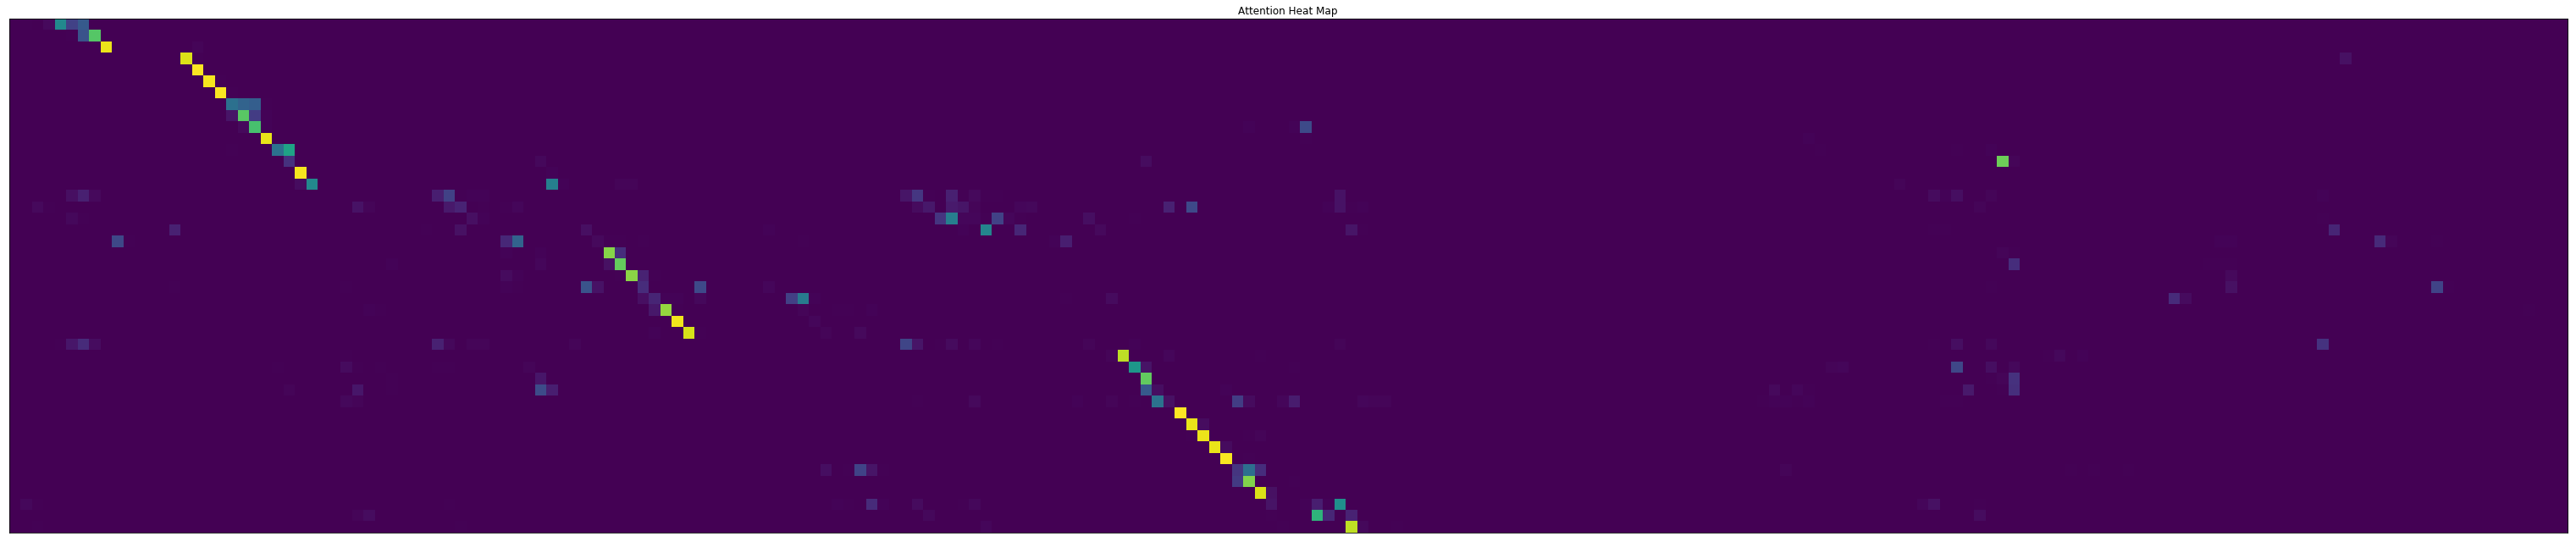

In [50]:
# atten_heatmap_filter(src[2], ref[2], gt_attens[2], 'heat_gt.png', thres = 0.2)
atten_heatmap(src[2], ref[2], gt_attens[2], 'heat_gt.png')

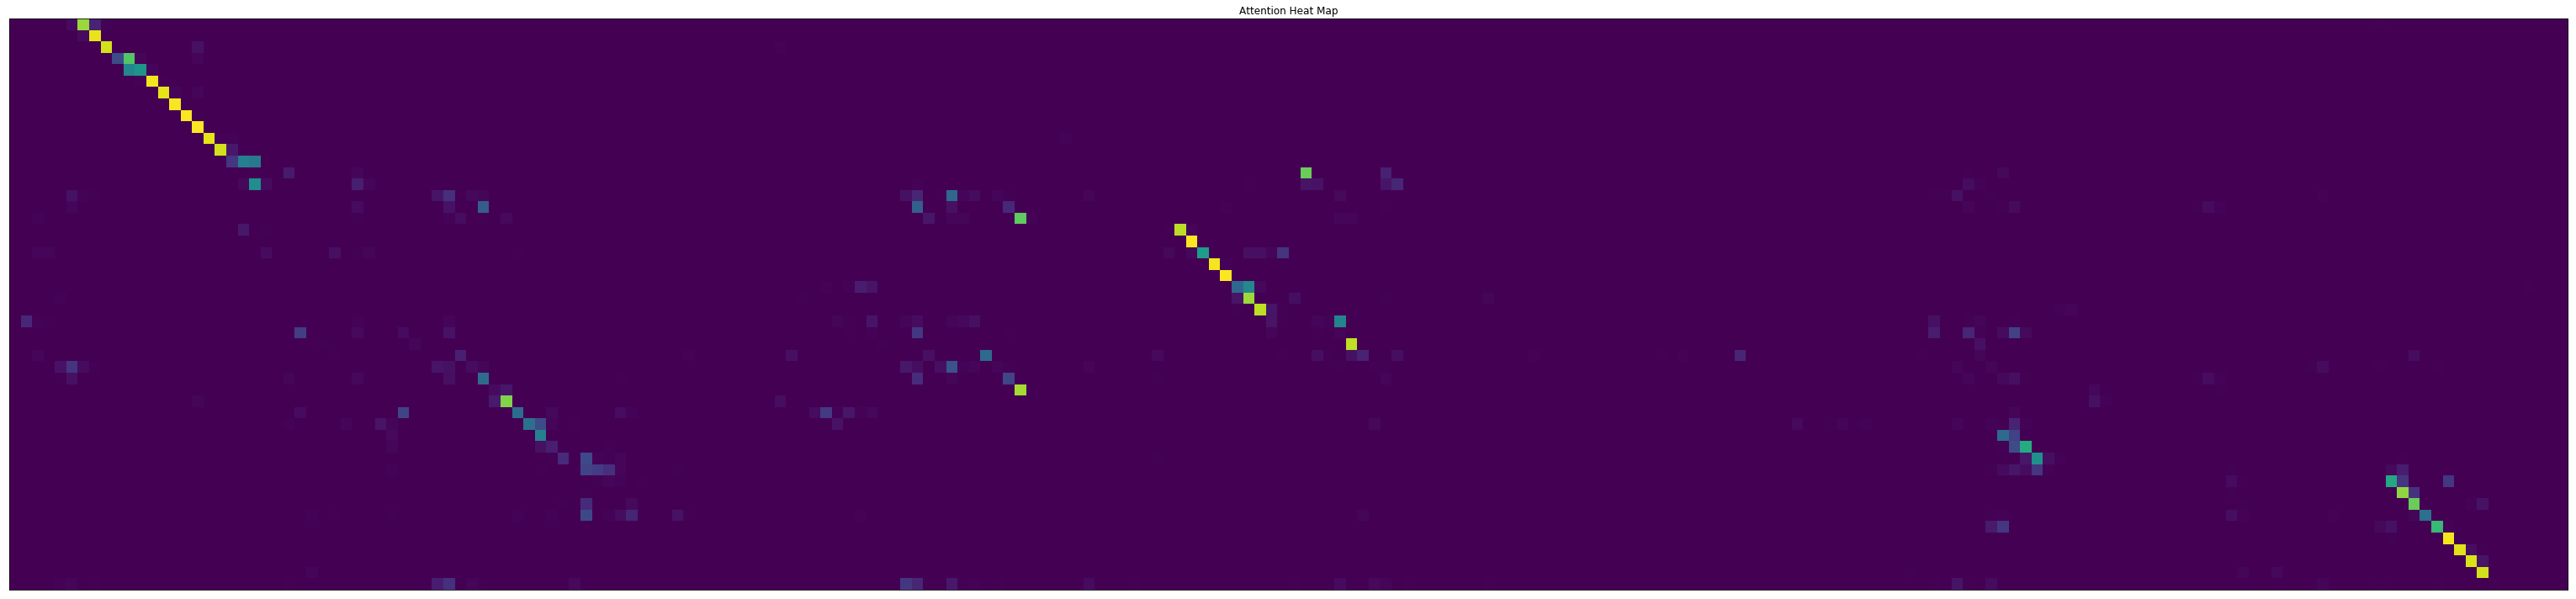

In [8]:
atten_heatmap(src[2], gen[2], attens[2], 'heat1_adv.png')

(36, 569)


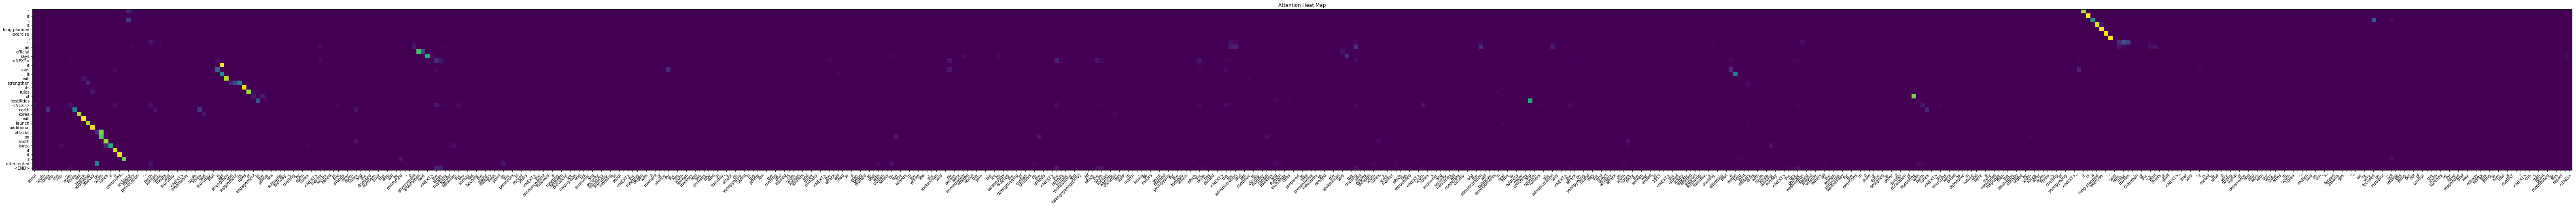

In [13]:
atten_heatmap(src[1][0], gen[1][0], attens[1][0], 'heat1_adv.png')

(50, 224)


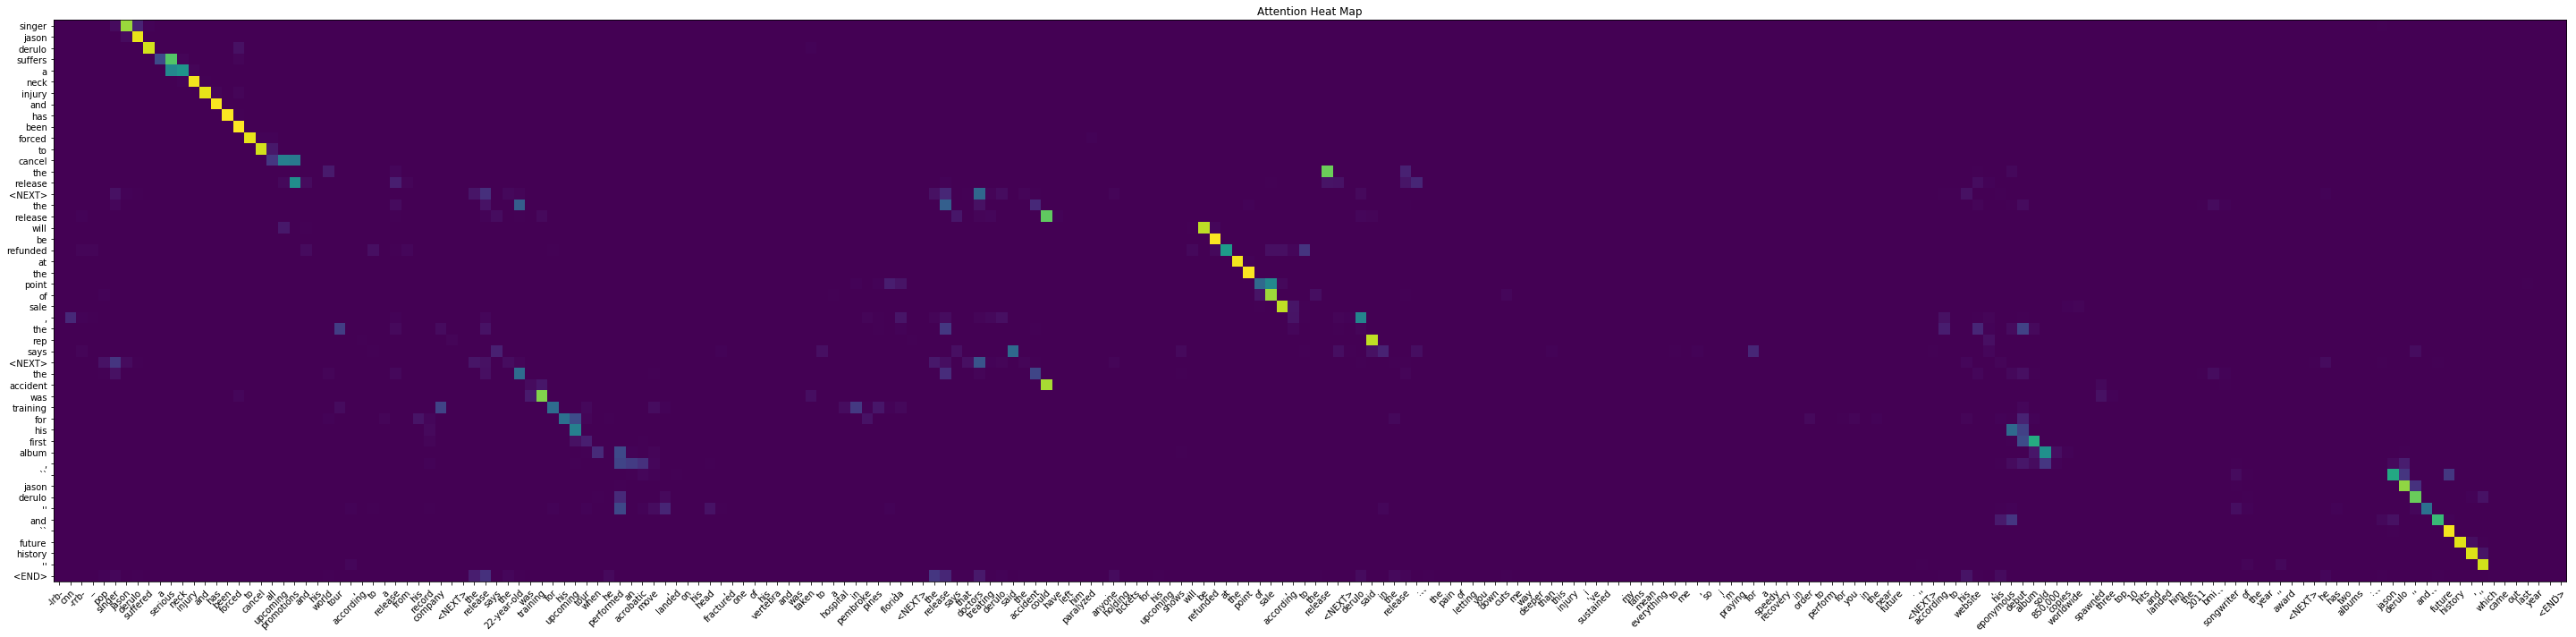

In [8]:
atten_heatmap(src[2], gen[2], attens[2], 'heat2_adv.png')

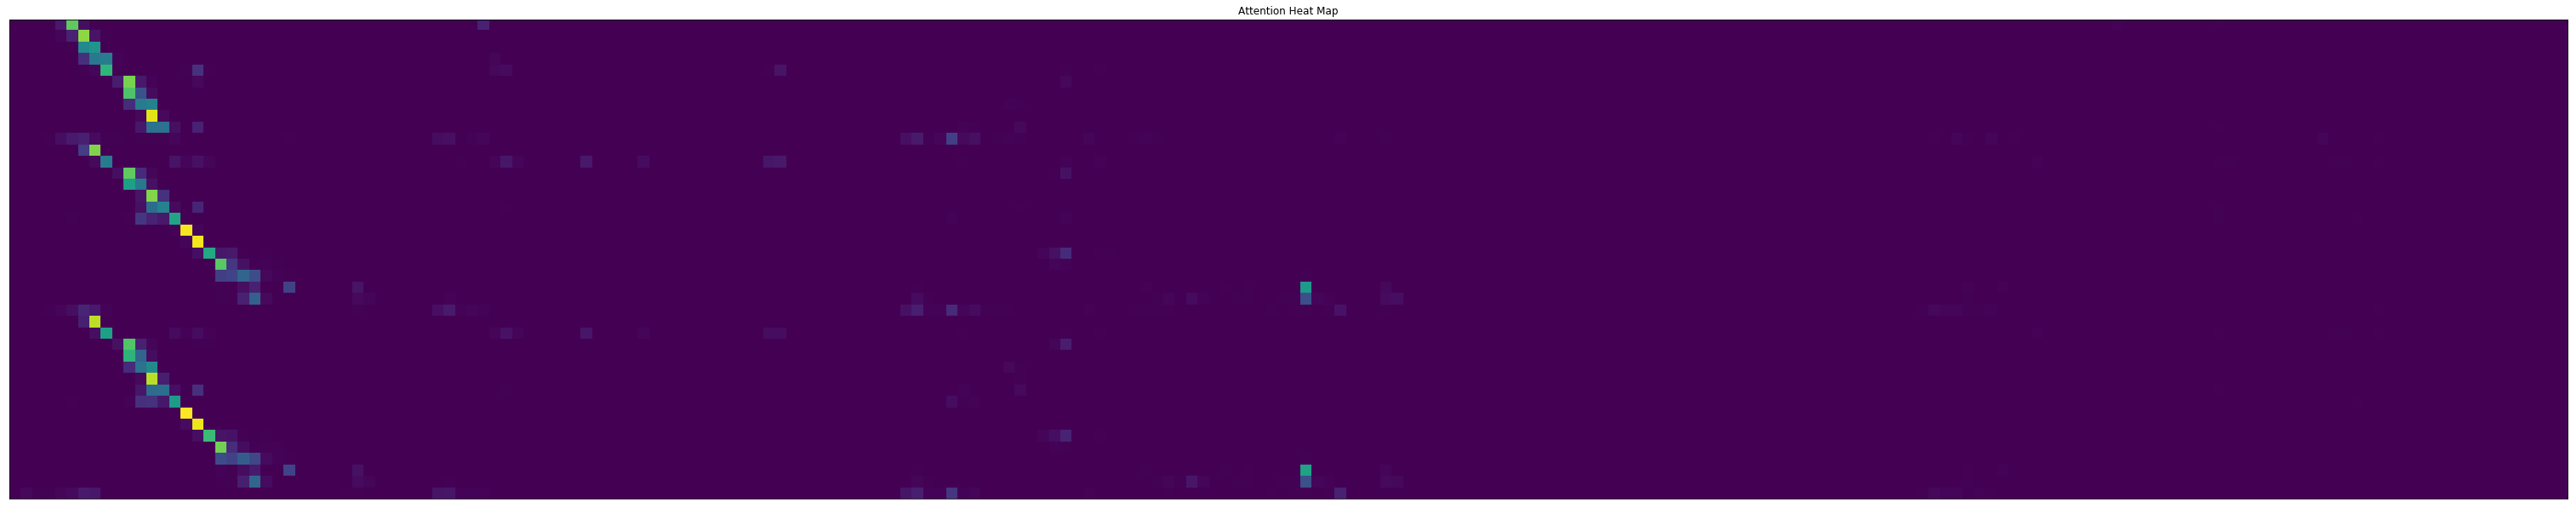

In [8]:
atten_heatmap(src[2], gen[2], attens[2], 'heat_no_cov.png')

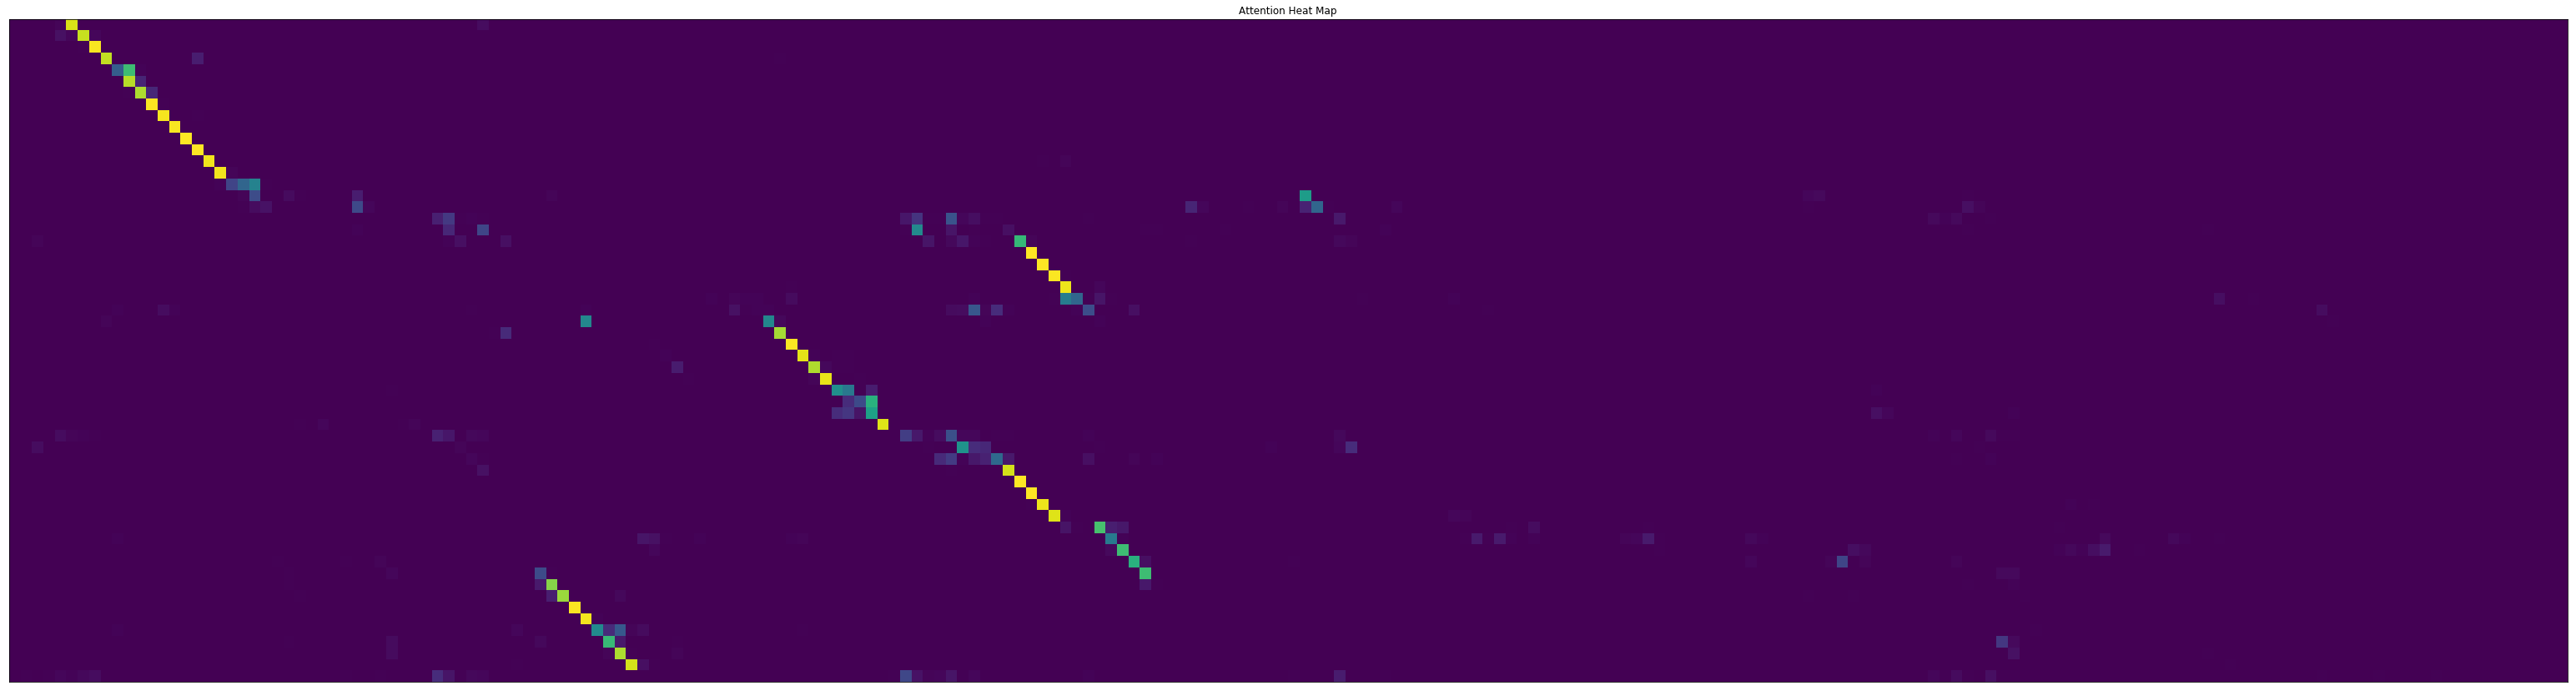

In [52]:
atten_heatmap(src[2], gen[2], attens[2], 'heat_cov.png')

In [ ]:
atten_heatmap(src[2], gen[2], attens[2], 'heat_gt_cov.png')

In [23]:
def sub_atten_heatmap(src, gen, atten, save_path):
    atten_map = np.array(atten)
    
    gen = gen[:min(len(gen), 15)]
    src = src[:min(len(src), 30)]
    atten_map = atten_map[:len(gen), :len(src)]
    print (atten_map.shape)

    fig, ax = plt.subplots()
    fig.set_size_inches(len(src) * 0.3, len(gen) * 0.3)
    im = ax.imshow(atten_map)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(src)))
    ax.set_yticks(np.arange(len(gen)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(src)
    ax.set_yticklabels(gen)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_yticklabels(), size = 12)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", size = 12)

    # Loop over data dimensions and create text annotations.
    '''
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, harvest[i, j],
                           ha="center", va="center", color="w")
    '''
    ax.set_title("Attention Heat Map")
    fig.tight_layout()
    plt.show()
    fig.savefig(save_path, bbox_inches='tight')

(15, 30)


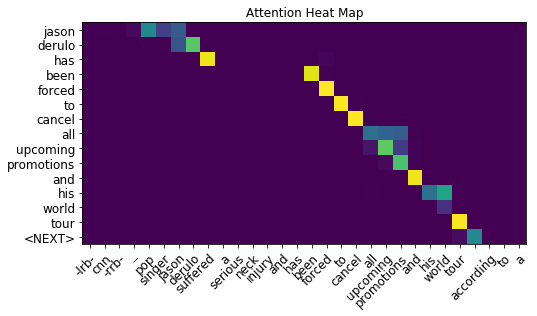

In [24]:
sub_atten_heatmap(src[2], ref[2], gt_attens[2], 'sub_heat1.png')

(15, 30)


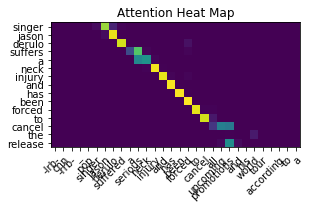

In [16]:
sub_atten_heatmap(src[2], gen[2], attens[2], 'sub_heat2.png')

#### Coverage Difference Test

In [4]:
test_n = min(data.n_test_batch, 1000)

def coverage_diff(gt_attens, attens, L1 = False, normal = True):
    gt_cov = np.sum(gt_attens, axis = 0)
    
    
    cov = np.sum(attens, axis = 0)
    if normal:
        gt_cov /= np.sum(gt_cov)
        cov /= np.sum(cov)
    if not L1:
        return np.sum(np.square(gt_cov - cov))
    else:
        return np.sum(np.abs(gt_cov - cov))

1. Adversarial

In [5]:
s = 0
test_data = data.get_next_epoch_test()
for feed_dict in tqdm_notebook(test_data, total = test_n):
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = True)
    src, ref, gen = data.id2word(feed_dict, tokens)
    feed_dict['coverage_on:0'] = True
    
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    for i in range(params['batch_size']):
        s += coverage_diff(gt_attens[i][:len(ref[i])], attens[i]) # adv
print (s / test_n / params['batch_size'])


0.015093216289463876


2. Coverage

In [6]:
s = 0
test_data = data.get_next_epoch_test()
for feed_dict in tqdm_notebook(test_data, total = test_n):
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = True)
    src, ref, gen = data.id2word(feed_dict, tokens)
    feed_dict['coverage_on:0'] = True
    # _, _, attens = model.beam_search(feed_dict, coverage_on = True)
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    for i in range(params['batch_size']):
        s += coverage_diff(gt_attens[i][:len(ref[i])], attens[i]) # adv
print (s / test_n / params['batch_size'])


0.014814468656274069


3. No Coverage

In [5]:
s = 0
cnt = 0
test_data = data.get_next_epoch_test()
for feed_dict in tqdm_notebook(test_data, total = test_n):
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = False)
    src, ref, gen = data.id2word(feed_dict, tokens)
    
    # _, _, attens = model.beam_search(feed_dict, coverage_on = True)
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    for i in range(params['batch_size']):
        if len(attens[i]) > 0:
            cnt += 1
            s += coverage_diff(gt_attens[i][:len(ref[i])], attens[i]) # no cov
            
print (s / cnt)


0.022094594940140065


In [5]:
s = 0
test_data = data.get_next_epoch_test()
for feed_dict in tqdm_notebook(test_data, total = test_n):
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = True)
    src, ref, gen = data.id2word(feed_dict, tokens)
    feed_dict['coverage_on:0'] = True
    
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    for i in range(params['batch_size']):
        s += coverage_diff(gt_attens[i][:len(ref[i])], attens[i], L1 = True) # adv
print (s / test_n / params['batch_size'])


1.2228424562850153


In [5]:
s = 0
test_data = data.get_next_epoch_test()
for feed_dict in tqdm_notebook(test_data, total = test_n):
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = True)
    src, ref, gen = data.id2word(feed_dict, tokens)
    feed_dict['coverage_on:0'] = True
    # _, _, attens = model.beam_search(feed_dict, coverage_on = True)
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    for i in range(params['batch_size']):
        s += coverage_diff(gt_attens[i][:len(ref[i])], attens[i], L1 = True) # cov
print (s / test_n / params['batch_size'])


1.248605562930778


In [5]:
s = 0
cnt = 0
test_data = data.get_next_epoch_test()
for feed_dict in tqdm_notebook(test_data, total = test_n):
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = False)
    src, ref, gen = data.id2word(feed_dict, tokens)
    
    # _, _, attens = model.beam_search(feed_dict, coverage_on = True)
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    for i in range(params['batch_size']):
        if len(attens[i]) > 0:
            cnt += 1
            s += coverage_diff(gt_attens[i][:len(ref[i])], attens[i], L1 = True) # no cov
            
print (s / cnt)


1.1490237668191399


In [5]:
s = 0
test_data = data.get_next_epoch_test()
for feed_dict in tqdm_notebook(test_data, total = test_n):
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = True)
    src, ref, gen = data.id2word(feed_dict, tokens)
    feed_dict['coverage_on:0'] = True
    
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    for i in range(params['batch_size']):
        s += coverage_diff(gt_attens[i][:len(ref[i])], attens[i], L1 = True, normal = False) # adv
print (s / test_n / params['batch_size'])


57.056370857010805


In [5]:
s = 0
test_data = data.get_next_epoch_test()
for feed_dict in tqdm_notebook(test_data, total = test_n):
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = True)
    src, ref, gen = data.id2word(feed_dict, tokens)
    feed_dict['coverage_on:0'] = True
    # _, _, attens = model.beam_search(feed_dict, coverage_on = True)
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    for i in range(params['batch_size']):
        s += coverage_diff(gt_attens[i][:len(ref[i])], attens[i], L1 = True, normal = False) # cov
print (s / test_n / params['batch_size'])


61.954951807661516


In [5]:
s = 0
cnt = 0
test_data = data.get_next_epoch_test()
for feed_dict in tqdm_notebook(test_data, total = test_n):
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = False)
    src, ref, gen = data.id2word(feed_dict, tokens)
    
    # _, _, attens = model.beam_search(feed_dict, coverage_on = True)
    gt_attens = model.sess.run(model.atten_dist, feed_dict = feed_dict)
    for i in range(params['batch_size']):
        if len(attens[i]) > 0:
            cnt += 1
            s += coverage_diff(gt_attens[i][:len(ref[i])], attens[i], L1 = True, normal = False) # no cov
            
print (s / cnt)


62.8817528024828


#### Calculate Loss for Test Data

In [ ]:
test_data = data.get_next_epoch_test()
print (model.test_one_epoch(test_data, data.n_test_batch))

#### Generate Results for Standard Tests

In [16]:
refs = []
gens = []

cnt = 0
test_n = min(data.n_test_batch, 1000)

test_data = data.get_next_epoch_test()

for feed_dict in tqdm_notebook(test_data, total = test_n):
    tokens, scores, attens = model.beam_search(feed_dict, coverage_on = True)
    # sample_tokens = model.sess.run(model.tokens, feed_dict = feed_dict)
    src, ref, gen = data.id2word(feed_dict, tokens)
    for i in range(len(ref)):
        refs.append(" ".join(ref[i][:-1]))
        gens.append(" ".join(gen[i][:-1]))
    cnt += 1
    if cnt > test_n:
        break
    

In [17]:
new_gens = []
new_refs = []
for i in range(len(gens)):
    if not (gens[i] == ""):
        new_gens.append(gens[i])
        new_refs.append(refs[i])

In [18]:
rouge_score = rouge.get_scores(new_gens, new_refs)

r1 = 0.
r2 = 0.
rl = 0.

for score in rouge_score:
    r1 = r1 + score['rouge-1']['f']
    r2 = r2 + score['rouge-2']['f']
    rl = rl + score['rouge-l']['f']

print (r1 / len(rouge_score))
print (r2 / len(rouge_score))
print (rl / len(rouge_score))

0.2970379924310778
0.08542048038874094
0.21153164463878796


In [19]:
import pickle
pickle.dump(new_refs, open('./result/adv_?/ref.p', 'wb'))
pickle.dump(new_gens, open('./result/adv_?/gen.p', 'wb'))

#### Test Attention Difference on One Model

In [ ]:
result_dirs = ['./result/adv_?/', './result/no_cov/', './result/cov_2/']
for dirs in result_dirs:
    load_ref = pickle.load(open(result_dirs + 'ref.p'))
    load_gen = pickle.load(open(result_dirs + 'gen.p'))
    

### Train Model
#### Train without coverage

In [ ]:
train_max_epoch = 10
print (f'Start from step {model.sess.run(model.gen_global_step)}')
for i in range(train_max_epoch):
    print (f'Train Epoch {i}')
    train_data = data.get_next_epoch()
    model.train_one_epoch(train_data, data.n_train_batch, coverage_on = False)

Start from step 61999
Train Epoch 0


#### Train with coverage

In [ ]:
train_max_epoch = 2
print (f'Start from step {model.sess.run(model.gen_global_step)}')
for i in range(train_max_epoch):
    print (f'Train Epoch {i}')
    train_data = data.get_next_epoch()
    model.train_one_epoch(train_data, data.n_train_batch, coverage_on = True, model_name = 'with_coverage')

Start from step 60877
Train Epoch 0


#### Train with GAN (Pretrain Discriminator)

In [4]:
train_max_epoch = 2
print (f'Start from step {model.sess.run(model.gen_global_step_2)}')
for i in range(train_max_epoch):
    print (f'Train Epoch {i}')
    train_data = data.get_next_epoch()
    model.train_one_epoch_pre_dis(train_data, data.n_train_batch, coverage_on = True)

Start from step 0
Train Epoch 0



Train Epoch 1


#### Train with GAN (Adversarial Training)

In [ ]:
train_max_epoch = 12
print (f'Start from step {model.sess.run(model.gen_global_step_2)}')
for i in range(train_max_epoch):
    print (f'Train Epoch {i}')
    train_data = data.get_next_epoch()
    model.train_one_epoch_unsup(train_data, data.n_train_batch, coverage_on = True)

Start from step 5668
Train Epoch 0


Restart Done!
Restart Done!
Restart Done!
Restart Done!
Restart Done!
Restart Done!
Restart Done!


In [ ]:
model.sess.run(model.real_reward, feed_dict = feed_dict)

In [ ]:
model._save_model(4, 'cov_after_4_epoch')

### Playground

In [5]:
var_dec = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'decoder')
var_enc = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'encoder')

In [6]:
model.sess.run(model.gen_prob, feed_dict = feed_dict)

array([[ -2.8118126 ,  -9.338753  ,  -3.4882824 , ..., -14.9608755 ,
        -15.03456   , -15.106922  ],
       [ -3.6509144 ,  -3.7761874 ,  -2.4939559 , ..., -25.019491  ,
        -18.362068  , -18.313862  ],
       [ -1.2580291 ,  -0.39334083,  -1.6343642 , ..., -17.03433   ,
        -17.025965  , -17.018969  ],
       ...,
       [ -1.8757198 ,  -6.1531897 ,  -4.7369475 , ..., -13.830263  ,
        -13.540183  , -13.1095915 ],
       [ -4.0941696 ,  -1.8114613 ,  -0.5785488 , ..., -12.332399  ,
        -12.179152  , -12.007977  ],
       [ -3.0196974 ,  -1.2873616 ,  -3.893816  , ..., -19.927132  ,
        -19.688524  , -19.548191  ]], dtype=float32)

In [ ]:
train_max_epoch = 2
print (f'Start from step {model.sess.run(model.gen_global_step)}')
for i in range(train_max_epoch):
    print (f'Train Epoch {i}')
    train_data = data.get_next_epoch()
    model.train_one_epoch(train_data, data.n_train_batch, coverage_on = True, model_name = 'with_coverage')

In [5]:
model._save_model(0, 'unsup_test_3')